In [1]:
import numpy as np
import pandas as pd
from nltk import FreqDist
from nltk.tokenize import \
    regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import plot_confusion_matrix
from scipy.stats import ttest_ind
import re
from collections import OrderedDict, defaultdict, Counter
import itertools
import string
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

pd.options.display.max_colwidth = 150
seed = 7

In [2]:
# Loading dataset

In [3]:
df = pd.read_csv('./data/disaster_tweets/train.csv')
df.head(10)

id keyword location  \
0   1     NaN      NaN   
1   4     NaN      NaN   
2   5     NaN      NaN   
3   6     NaN      NaN   
4   7     NaN      NaN   
5   8     NaN      NaN   
6  10     NaN      NaN   
7  13     NaN      NaN   
8  14     NaN      NaN   
9  15     NaN      NaN   

                                                                                                                                    text  \
0                                                                  Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all   
1                                                                                                 Forest fire near La Ronge Sask. Canada   
2  All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected   
3                                                                      13,000 people receive #wildfires evacuation orders in California    
4                                               Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school    
5                         #RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires   
6                                        #flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas   
7                                                                            I'm on top of the hill and I can see a fire in the woods...   
8                                                        There's an emergency evacuation happening now in the building across the street   
9                                                                                   I'm afraid that the tornado is coming to our area...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  
5       1  
6       1  
7       1  
8       1  
9       1

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [5]:
df.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [6]:
# Keyword and location columns

In [7]:
# Location column doesn't seem to have usable information. In some cases it's nonsense.

In [8]:
print('Sample of some of the location values')
df['location'].unique()[7:17].tolist()

Sample of some of the location values


['World Wide!!',
 'Paranaque City',
 'Live On Webcam',
 'milky way',
 'GREENSBORO,NORTH CAROLINA',
 'England.',
 'Sheffield Township, Ohio',
 'India',
 'Barbados',
 'Anaheim']

In [9]:
Counter(df['keyword'])

Counter({nan: 61,
         'ablaze': 36,
         'accident': 35,
         'aftershock': 34,
         'airplane%20accident': 35,
         'ambulance': 38,
         'annihilated': 34,
         'annihilation': 29,
         'apocalypse': 32,
         'armageddon': 42,
         'army': 34,
         'arson': 32,
         'arsonist': 34,
         'attack': 36,
         'attacked': 35,
         'avalanche': 30,
         'battle': 26,
         'bioterror': 37,
         'bioterrorism': 30,
         'blaze': 38,
         'blazing': 34,
         'bleeding': 35,
         'blew%20up': 33,
         'blight': 32,
         'blizzard': 37,
         'blood': 35,
         'bloody': 35,
         'blown%20up': 33,
         'body%20bag': 33,
         'body%20bagging': 33,
         'body%20bags': 41,
         'bomb': 34,
         'bombed': 38,
         'bombing': 29,
         'bridge%20collapse': 35,
         'buildings%20burning': 35,
         'buildings%20on%20fire': 33,
         'burned': 33,
         'bu

In [10]:
# I don't plan to use 'keyword' as a feature.
# It's just what was used to search for tweets.
# Filling missing values with 'missing_keyword' so I can visualize.

In [11]:
df['keyword'] = df['keyword'].fillna('missing_keyword')

In [12]:
df['keyword_count_0'] = \
    df['keyword'].apply(
        lambda x: Counter(df['keyword'][df['target'] == 0])[x]
        )
df['keyword_count_1'] = \
    df['keyword'].apply(
        lambda x: Counter(df['keyword'][df['target'] == 1])[x]
        )

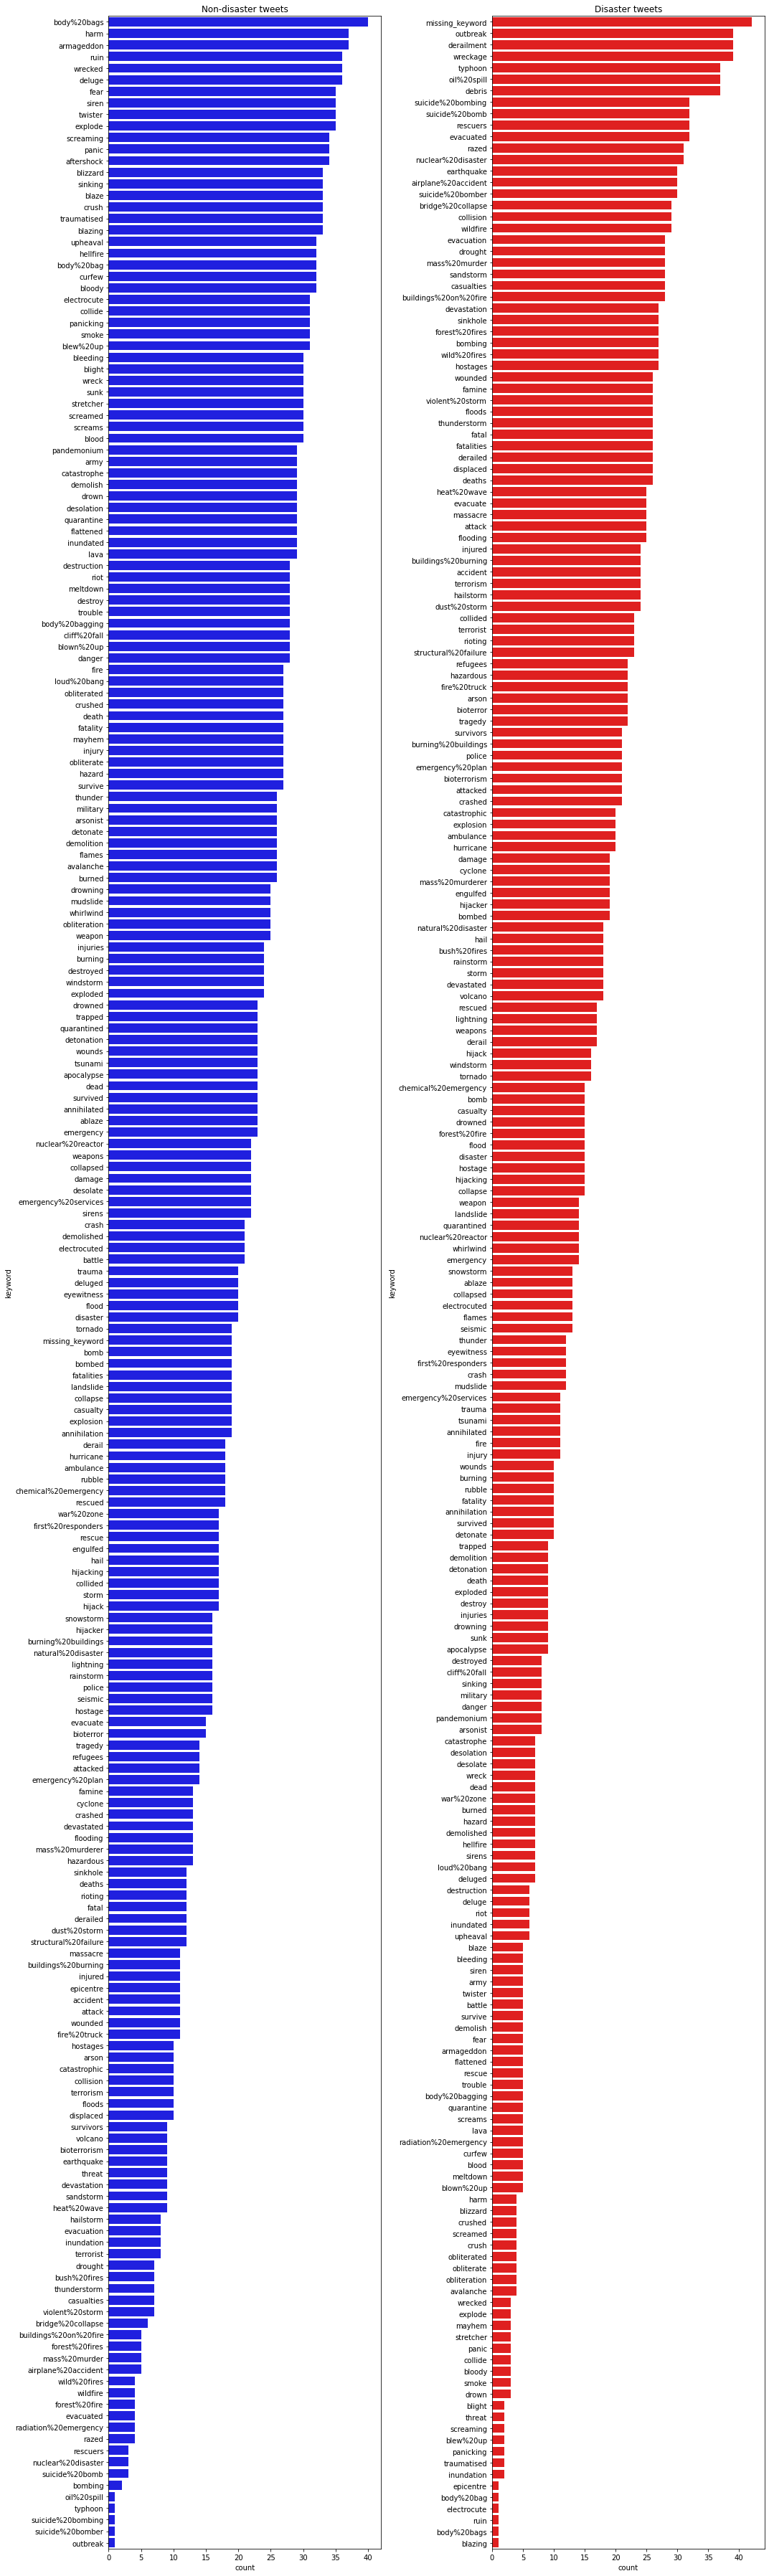

In [13]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 50))

sns.countplot(
    y=df[df['target']==0].sort_values(
        by='keyword_count_0', ascending=False
        )['keyword'],
    color='blue',
    ax=axes[0]
    )
sns.countplot(
    y=df[df['target']==1].sort_values(
        by='keyword_count_1', ascending=False
        )['keyword'],
    color='red',
    ax=axes[1]
    )

axes[0].set_title('Non-disaster tweets')
axes[1].set_title('Disaster tweets')

plt.tight_layout()
plt.show()

In [14]:
# Features and Target

In [15]:
tweets = df[['text']]
target = df['target']

In [16]:
print('Distribution of Target')
print
print(target.value_counts())
print()
print(target.value_counts(normalize=True))

Distribution of Target
0    4342
1    3271
Name: target, dtype: int64

0    0.57034
1    0.42966
Name: target, dtype: float64


In [17]:
# Train Test Split

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    tweets, target, test_size=.25, random_state=seed
)

In [19]:
# Cleaning and tokenizing the tweet text

In [20]:
# Saving a copy of untouched tweets
X_train_tweets_unprocessed = X_train.copy()['text'] 

X_test_tweets_unprocessed = X_test.copy()['text'] 

In [21]:
X_train['text'] = X_train['text'].apply(lambda x: x.lower())

X_test['text'] = X_test['text'].apply(lambda x: x.lower())

<ipython-input-21-fe8ae85085f2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['text'] = X_train['text'].apply(lambda x: x.lower())
<ipython-input-21-fe8ae85085f2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['text'] = X_test['text'].apply(lambda x: x.lower())


In [22]:
X_train.head(10)

text
1489    @masochisticmage + catastrophe! it caused people to get reckless and the bottom line is that at least three of your friends will have +
5973                                                                                                         #nochilllukehammings\nim screaming
7589                                                                                                                             omg earthquake
3788  it's never a good sign when you pull up to work &amp; there's five ambulances &amp; a fire truck in the bay. wompppp at least it's friday
825                                                                                            my mic and controllers aren't working one second
4569         my baby girls car wreak this afternoon thank god no serious injuries and she was wearing her seatbelt!!!... http://t.co/njqv45nds2
6371    look at the previous battles. citizens were committing suicide so to not be under american control. the bomb was the only way. @nbcnews
4648                                                                              @mistresspip i'm amazed you have not been inundated mistress.
1812                                                       maj muzzamil pilot offr of mi-17 crashed near mansehra today. http://t.co/kl4r1ccwct
492                  christian attacked by muslims at the temple mount after waving israeli flag via pamela geller - ... http://t.co/f5miuhqaby

In [23]:
# Remove URLs

In [24]:
# Preserve if tweet has a URL. Will use this later.

def binary_url(text):
    """
    Returns 1 if a string contains a URL, else returns 0.
    """
    search = re.search(pattern=r'http\S+', string=text)
    return int(bool(search))

has_url_Series_train = X_train['text'].apply(binary_url).rename('has_url')
has_url_Series_test = X_test['text'].apply(binary_url).rename('has_url')

In [25]:
X_train['text'] = X_train['text'].apply(
    lambda x: re.sub(pattern=r'http\S+', repl='', string=x)
    )

X_test['text'] = X_test['text'].apply(
    lambda x: re.sub(pattern=r'http\S+', repl='', string=x)
    )

<ipython-input-25-0ca44001ae68>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['text'] = X_train['text'].apply(
<ipython-input-25-0ca44001ae68>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['text'] = X_test['text'].apply(


In [26]:
# Tokenizing

In [27]:
example_tweet = X_train['text'].loc[2372]
example_tweet

"such activities of govt can't derail us from our aim &amp; we still remain peaceful and unite for #freesikhpoliticalprisnors &amp; @bapusuratsingh"

In [28]:
X_train['text'].sample(5)

4962                                                        commoditiesåêare crashing like it's 2008 all over again  via @business
4313                          hellfire is surrounded by desires so be careful and donûªt let your desires control you! #afterlife
4647    kids are inundated with images and information online and in media and have no way to deconstruct. - kerri sackville #tms7
1685                                                                 check out my new song 'collide' live at the bowery electric! 
1158        japan marks 70th anniversary of hiroshima atomic bombing: bells tolled in hiroshima on thursday as japan marked 70û_ 
Name: text, dtype: object

In [29]:
token_pattern = r"[a-zA-Z]+'?[a-zA-Z]+"
# Pattern: Any alphanumeric word with at least two characters, including up to one apostrophy

tokenizer = RegexpTokenizer(token_pattern)

In [30]:
tokenizer.tokenize(example_tweet)

['such',
 'activities',
 'of',
 'govt',
 "can't",
 'derail',
 'us',
 'from',
 'our',
 'aim',
 'amp',
 'we',
 'still',
 'remain',
 'peaceful',
 'and',
 'unite',
 'for',
 'freesikhpoliticalprisnors',
 'amp',
 'bapusuratsingh']

In [31]:
# seems to work
# But "amp" is an artifact of "&amp;" which is the HTML entity for "&"
# Replace it with "and" in original text
# Then tokenize

In [32]:
X_train['text'] = X_train['text'].apply(lambda x: re.sub("&amp;", "and", x))

X_test['text'] = X_test['text'].apply(lambda x: re.sub("&amp;", "and", x))

<ipython-input-32-5db425f8e032>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['text'] = X_train['text'].apply(lambda x: re.sub("&amp;", "and", x))
<ipython-input-32-5db425f8e032>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['text'] = X_test['text'].apply(lambda x: re.sub("&amp;", "and", x))


In [33]:
X_train['tokens'] = X_train['text'].apply(tokenizer.tokenize)

X_test['tokens'] = X_test['text'].apply(tokenizer.tokenize)

<ipython-input-33-8f8e129d577d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['tokens'] = X_train['text'].apply(tokenizer.tokenize)
<ipython-input-33-8f8e129d577d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['tokens'] = X_test['text'].apply(tokenizer.tokenize)


In [34]:
# Remove stopwords
# Get comprehensive list
# Combine stopwords from two libraries: NLTK and SpaCy

In [35]:
sw_spacy = list(nlp.Defaults.stop_words)
sw_nltk = stopwords.words('english')
stopword_list = list(set(sw_spacy + sw_nltk))

In [36]:
X_train['tokens_no_sw'] = \
    X_train['tokens'].apply(
        lambda x: [w for w in x if not w in stopword_list]
    )

X_test['tokens_no_sw'] = \
    X_test['tokens'].apply(
        lambda x: [w for w in x if not w in stopword_list]
    )

<ipython-input-36-c37e4e8dbe90>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['tokens_no_sw'] = \
<ipython-input-36-c37e4e8dbe90>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['tokens_no_sw'] = \


In [37]:
# Check most common words

In [38]:
FreqDist(X_train['tokens_no_sw'].explode()).most_common(20)

[('like', 264),
 ('fire', 200),
 ("i'm", 184),
 ('new', 176),
 ('news', 164),
 ('people', 151),
 ('video', 119),
 ('disaster', 115),
 ('police', 110),
 ('emergency', 108),
 ('time', 101),
 ('body', 95),
 ('suicide', 90),
 ('california', 90),
 ('storm', 90),
 ('burning', 89),
 ('rt', 88),
 ('crash', 87),
 ('world', 84),
 ('man', 83)]

In [39]:
# "i'm" should also be considered a stop word

In [40]:
stopword_list.extend(["i'm"])

In [41]:
X_train['tokens_no_sw'] = \
    X_train['tokens'].apply(
        lambda x: [w for w in x if not w in stopword_list]
    )

X_test['tokens_no_sw'] = \
    X_test['tokens'].apply(
        lambda x: [w for w in x if not w in stopword_list]
    )

<ipython-input-41-c37e4e8dbe90>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['tokens_no_sw'] = \
<ipython-input-41-c37e4e8dbe90>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['tokens_no_sw'] = \


In [42]:
top_20_no_sw = FreqDist(X_train['tokens_no_sw'].explode()).most_common(20)
top_20_no_sw

[('like', 264),
 ('fire', 200),
 ('new', 176),
 ('news', 164),
 ('people', 151),
 ('video', 119),
 ('disaster', 115),
 ('police', 110),
 ('emergency', 108),
 ('time', 101),
 ('body', 95),
 ('suicide', 90),
 ('california', 90),
 ('storm', 90),
 ('burning', 89),
 ('rt', 88),
 ('crash', 87),
 ('world', 84),
 ('man', 83),
 ('bomb', 82)]

In [43]:
X_train.head()

text  \
1489  @masochisticmage + catastrophe! it caused people to get reckless and the bottom line is that at least three of your friends will have +   
5973                                                                                                       #nochilllukehammings\nim screaming   
7589                                                                                                                           omg earthquake   
3788    it's never a good sign when you pull up to work and there's five ambulances and a fire truck in the bay. wompppp at least it's friday   
825                                                                                          my mic and controllers aren't working one second   

                                                                                                                                                     tokens  \
1489  [masochisticmage, catastrophe, it, caused, people, to, get, reckless, and, the, bottom, line, is, that, at, least, three, of, your, friends, will,...   
5973                                                                                                                   [nochilllukehammings, im, screaming]   
7589                                                                                                                                      [omg, earthquake]   
3788  [it's, never, good, sign, when, you, pull, up, to, work, and, there's, five, ambulances, and, fire, truck, in, the, bay, wompppp, at, least, it's,...   
825                                                                                               [my, mic, and, controllers, aren't, working, one, second]   

                                                                          tokens_no_sw  
1489           [masochisticmage, catastrophe, caused, people, reckless, line, friends]  
5973                                              [nochilllukehammings, im, screaming]  
7589                                                                 [omg, earthquake]  
3788  [good, sign, pull, work, there's, ambulances, fire, truck, bay, wompppp, friday]  
825                                                [mic, controllers, working, second]

In [44]:
# Linguistic Feature engineering 

In [45]:
# Using SpaCy to lemmatize our text
# Using SpaCy to count NER tags and POS tags
# NER tags I'm interested in:
## GPE, LOC, NORP, FAC, EVENT, ORG

In [46]:
# SpaCy Lemmatize

def spacy_lemmatize(text):
    tokens = tokenizer.tokenize(text)
    # Function uses the tokenizer I previously set up
    doc = nlp(' '.join(tokens))
    return [t.lemma_.lower() for t in doc]

X_train['lemmas'] = X_train['text'].apply(spacy_lemmatize)
X_train['lemmas_no_sw'] = X_train['lemmas'].apply(
    lambda x: [l for l in x if l not in stopword_list]
    )

X_test['lemmas'] = X_test['text'].apply(spacy_lemmatize)
X_test['lemmas_no_sw'] = X_test['lemmas'].apply(
    lambda x: [l for l in x if l not in stopword_list]
    )

<ipython-input-46-61f5a1d980b5>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['lemmas'] = X_train['text'].apply(spacy_lemmatize)
<ipython-input-46-61f5a1d980b5>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['lemmas_no_sw'] = X_train['lemmas'].apply(
<ipython-input-46-61f5a1d980b5>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.p

In [47]:
# Spacy POS

def spacy_pos(text):
    """
    Takes in a string and returns a list of part-of-speech tokens.
    """
    tokens = tokenizer.tokenize(text)
    doc = nlp(' '.join(tokens))
    pos_tokens = [t.pos_ for t in doc]
    return pos_tokens

X_train['text_as_POS'] = X_train['text'].apply(spacy_pos)

X_test['text_as_POS'] = X_test['text'].apply(spacy_pos)

<ipython-input-47-29c9804b2ecd>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['text_as_POS'] = X_train['text'].apply(spacy_pos)
<ipython-input-47-29c9804b2ecd>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['text_as_POS'] = X_test['text'].apply(spacy_pos)


In [48]:
# Making dataframes of vectorized POS tags

pos_vec = CountVectorizer(tokenizer=spacy_pos)
pos_vectorized_train = pos_vec.fit_transform(X_train['text'])
pos_vectorized_df_train = pd.DataFrame(
        pos_vectorized_train.toarray(),
        columns=pos_vec.get_feature_names(),
        index=X_train.index
)

pos_vectorized_test = pos_vec.transform(X_test['text'])
pos_vectorized_df_test = pd.DataFrame(
        pos_vectorized_test.toarray(),
        columns=pos_vec.get_feature_names(),
        index=X_test.index
)

In [49]:
X_train.head()

text  \
1489  @masochisticmage + catastrophe! it caused people to get reckless and the bottom line is that at least three of your friends will have +   
5973                                                                                                       #nochilllukehammings\nim screaming   
7589                                                                                                                           omg earthquake   
3788    it's never a good sign when you pull up to work and there's five ambulances and a fire truck in the bay. wompppp at least it's friday   
825                                                                                          my mic and controllers aren't working one second   

                                                                                                                                                     tokens  \
1489  [masochisticmage, catastrophe, it, caused, people, to, get, reckless, and, the, bottom, line, is, that, at, least, three, of, your, friends, will,...   
5973                                                                                                                   [nochilllukehammings, im, screaming]   
7589                                                                                                                                      [omg, earthquake]   
3788  [it's, never, good, sign, when, you, pull, up, to, work, and, there's, five, ambulances, and, fire, truck, in, the, bay, wompppp, at, least, it's,...   
825                                                                                               [my, mic, and, controllers, aren't, working, one, second]   

                                                                          tokens_no_sw  \
1489           [masochisticmage, catastrophe, caused, people, reckless, line, friends]   
5973                                              [nochilllukehammings, im, screaming]   
7589                                                                 [omg, earthquake]   
3788  [good, sign, pull, work, there's, ambulances, fire, truck, bay, wompppp, friday]   
825                                                [mic, controllers, working, second]   

                                                                                                                                                     lemmas  \
1489  [masochisticmage, catastrophe, it, cause, people, to, get, reckless, and, the, bottom, line, be, that, at, least, three, of, your, friend, will, h...   
5973                                                                                                                     [nochilllukehamming, i, m, scream]   
7589                                                                                                                                      [omg, earthquake]   
3788  [it, be, never, good, sign, when, you, pull, up, to, work, and, there, be, five, ambulance, and, fire, truck, in, the, bay, wompppp, at, least, it...   
825                                                                                                  [my, mic, and, controller, be, not, work, one, second]   

                                                                lemmas_no_sw  \
1489   [masochisticmage, catastrophe, cause, people, reckless, line, friend]   
5973                                            [nochilllukehamming, scream]   
7589                                                       [omg, earthquake]   
3788  [good, sign, pull, work, ambulance, fire, truck, bay, wompppp, friday]   
825                                          [mic, controller, work, second]   

                                                                                                                                                text_as_POS  
1489                          [NOUN, NOUN, PRON, VERB, NOUN, PART, VERB, ADJ, CCONJ, DET, ADJ, NOUN, AUX, SCONJ, ADV, ADV, NUM, ADP, PRON, NOUN, AUX, VERB]  
5973              

In [50]:
pos_vectorized_df_train.head()

ADJ  ADP  ADV  AUX  CCONJ  DET  INTJ  NOUN  NUM  PART  PRON  PROPN  \
1489    2    1    2    2      1    1     0     5    1     1     2      0   
5973    0    0    0    1      0    0     0     1    0     0     1      0   
7589    0    0    0    0      0    0     0     1    0     0     0      1   
3788    2    4    1    2      2    1     0     6    1     0     4      2   
825     0    0    0    1      1    0     0     3    1     1     1      0   

      PUNCT  SCONJ  VERB  X  
1489      0      1     3  0  
5973      0      0     1  0  
7589      0      0     0  0  
3788      0      1     2  0  
825       0      0     1  0

In [51]:
# Spacy NER

def spacy_ner(
    text, 
    ner_tags=['GPE', 'LOC', 'NORP', 'ORG', 'FAC']
    ):
    """
    Helper function.
    Takes in a string and returns a list of named-entity recognition tags.
    Also takes in a specific list of NER tags to look for.
    To look for all NER tags supported by SpaCy, set `ner_tags=None`.
    Intended use is to use this function as a tokenizer in an sklearn vectorizor.
    """
    tokens = tokenizer.tokenize(text)
    doc = nlp(' '.join(tokens))
    ents = doc.ents
    if ner_tags:
        tags = [ent.label_ for ent in doc.ents if ent.label_ in ner_tags]
        return tags
    else:
        tags = [ent.label_ for ent in doc.ents]
        return tags

In [52]:
# Making dataframes of vectorized NER tags

ner_vec = CountVectorizer(tokenizer=spacy_ner)
ner_vectorized_train = ner_vec.fit_transform(X_train['text'])
ner_vectorized_df_train = pd.DataFrame(
        ner_vectorized_train.toarray(),
        columns=ner_vec.get_feature_names(),
        index=X_train.index
)

ner_vectorized_test = ner_vec.transform(X_test['text'])
ner_vectorized_df_test = pd.DataFrame(
        ner_vectorized_test.toarray(),
        columns=ner_vec.get_feature_names(),
        index=X_test.index
)

In [53]:
ner_vectorized_df_train.head(10)

FAC  GPE  LOC  NORP  ORG
1489    0    0    0     0    0
5973    0    0    0     0    0
7589    0    0    0     0    0
3788    0    0    1     0    0
825     0    0    0     0    0
4569    0    0    0     0    0
6371    0    0    0     1    0
4648    0    0    0     0    0
1812    0    0    0     0    0
492     0    0    1     3    0

In [54]:
# Meta Feature engineering

# Has URL
# Character count
# Length of tokens
# Number of tokens
# Number of unique tokens
# hashtags? mentions?

In [55]:
#  Which version of tokens have the biggest disparity between classes?

In [93]:
# Average length of token

for column in ['tokens','tokens_no_sw', 'lemmas', 'lemmas_no_sw']:
    tokens = X_train[column][X_train[column].apply(lambda x: x != [])]
    average_length_0 = \
        tokens[y_train==0].apply(lambda x: np.mean([len(t) for t in x]))
    average_length_1 = \
        tokens[y_train==1].apply(lambda x: np.mean([len(t) for t in x]))
    t_test = ttest_ind(average_length_0, average_length_1)
    print(f'{column:{20}}{t_test}')

tokens              Ttest_indResult(statistic=-10.888796396358687, pvalue=2.4174752089914336e-27)
tokens_no_sw        Ttest_indResult(statistic=-7.252232336056516, pvalue=4.645366502067098e-13)
lemmas              Ttest_indResult(statistic=-11.611871549172264, pvalue=7.948479235164981e-31)
lemmas_no_sw        Ttest_indResult(statistic=-5.896280259329194, pvalue=3.931008181791307e-09)


In [57]:
# lemmas with stopwords

In [99]:
# Number of tokens

for column in ['tokens','tokens_no_sw', 'lemmas', 'lemmas_no_sw']:
    average_length_0 = \
        X_train[column][y_train==0].apply(len).dropna()
    average_length_1 = \
        X_train[column][y_train==1].apply(len).dropna()
    t_test = ttest_ind(average_length_0, average_length_1)
    print(f'{column:{20}}{t_test}')

tokens              Ttest_indResult(statistic=-1.678955081768617, pvalue=0.09321554140560237)
tokens_no_sw        Ttest_indResult(statistic=-11.994417135481633, pvalue=9.38714082821458e-33)
lemmas              Ttest_indResult(statistic=-0.664126802322163, pvalue=0.5066359869017423)
lemmas_no_sw        Ttest_indResult(statistic=-12.973616145683863, pvalue=5.917664995247145e-38)


In [59]:
# Lemmas no stopwords

In [102]:
# Number of unique tokens

for column in ['tokens','tokens_no_sw', 'lemmas', 'lemmas_no_sw']:
    average_length_0 = \
        X_train[column][y_train==0].apply(lambda x: len(set(x))).dropna()
    average_length_1 = \
        X_train[column][y_train==1].apply(lambda x: len(set(x))).dropna()
    t_test = ttest_ind(average_length_0, average_length_1)
    print(f'{column:{20}}{t_test}')

tokens              Ttest_indResult(statistic=-1.8296863997564934, pvalue=0.06734898548241941)
tokens_no_sw        Ttest_indResult(statistic=-11.408711773799919, pvalue=7.946716409714468e-30)
lemmas              Ttest_indResult(statistic=-1.1392513127629718, pvalue=0.254646164360224)
lemmas_no_sw        Ttest_indResult(statistic=-12.31244374235127, pvalue=2.1152490716926553e-34)


In [61]:
# Lemmas no stopwords

In [62]:
# has_url_Series already exists
# Start a DF with it

meta_features_df_train = pd.DataFrame(has_url_Series_train)

# Character count. Original tweet. No URL.
meta_features_df_train['character_count'] = \
    X_train['text'].apply(len)

# Stop word count. Original tweet. No URL.
meta_features_df_train['sw_count'] = \
    X_train['tokens'].apply(lambda x: len([w for w in x if w in stopword_list]))

# Average lemma length. Including stop words.
meta_features_df_train['mean_lemma_length'] = \
    X_train['lemmas'].apply(lambda x: np.mean([len(t) for t in x]))

# Lemma count. No stop words.
meta_features_df_train['lemma_count_no_sw'] = \
    X_train['lemmas_no_sw'].apply(len)

# Number of unique lemmas. No stop words.
meta_features_df_train['unique_lemmas_no_sw'] = \
    X_train['lemmas_no_sw'].apply(lambda x: len(set(x)))

# Punctuation count
tweet_punctuation = \
    string.punctuation.replace('#', '').replace('@', '')
meta_features_df_train['punct_count'] = \
    X_train['text'].apply(
        lambda x: len([c for c in x if c in tweet_punctuation])
        )

# Hashtag count
meta_features_df_train['hashtag_count'] = \
    X_train['text'].apply(lambda x: len(re.findall(r'#{1}\w+', x)))

meta_features_df_train['mention_count'] = \
    X_train['text'].apply(lambda x: len(re.findall(r'@{1}\w+', x)))

meta_features_df_train.head()

has_url  character_count  sw_count  mean_lemma_length  \
1489        0              135        15           4.818182   
5973        0               33         0           6.500000   
7589        0               14         0           6.500000   
3788        0              133        14           3.678571   
825         0               48         4           4.000000   

      lemma_count_no_sw  unique_lemmas_no_sw  punct_count  hashtag_count  \
1489                  7                    7            3              0   
5973                  2                    2            0              1   
7589                  2                    2            0              0   
3788                 10                   10            4              0   
825                   4                    4            1              0   

      mention_count  
1489              1  
5973              0  
7589              0  
3788              0  
825               0

In [63]:
# Repeat the above with the test set

meta_features_df_test = pd.DataFrame(has_url_Series_test)

# Character count. Original tweet. No URL.
meta_features_df_test['character_count'] = \
    X_test['text'].apply(len)

# Stop word count. Original tweet. No URL.
meta_features_df_test['sw_count'] = \
    X_test['tokens'].apply(lambda x: len([w for w in x if w in stopword_list]))

# Average lemma length. Including stop words.
meta_features_df_test['mean_lemma_length'] = \
    X_test['lemmas'].apply(lambda x: np.mean([len(t) for t in x]))

# Lemma count. No stop words.
meta_features_df_test['lemma_count_no_sw'] = \
    X_test['lemmas_no_sw'].apply(len)

# Number of unique lemmas. No stop words.
meta_features_df_test['unique_lemmas_no_sw'] = \
    X_test['lemmas_no_sw'].apply(lambda x: len(set(x)))

# Punctuation count
tweet_punctuation = \
    string.punctuation.replace('#', '').replace('@', '')
meta_features_df_test['punct_count'] = \
    X_test['text'].apply(
        lambda x: len([c for c in x if c in tweet_punctuation])
        )

# Hashtag count
meta_features_df_test['hashtag_count'] = \
    X_test['text'].apply(lambda x: len(re.findall(r'#{1}\w+', x)))

meta_features_df_test['mention_count'] = \
    X_test['text'].apply(lambda x: len(re.findall(r'@{1}\w+', x)))

In [64]:
# VISUALIZING

In [65]:
color_non = '#2c2fbf'
color_disaster ='#f14848'
kwargs_distplot = {'kde':True, 'stat':"density", 'linewidth':0}

<AxesSubplot:xlabel='mean_lemma_length', ylabel='Density'>

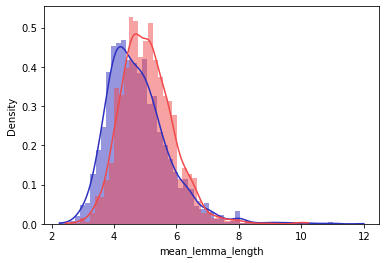

In [66]:
sns.histplot(meta_features_df_train['mean_lemma_length'][y_train==0], **kwargs_distplot, color=color_non)
sns.histplot(meta_features_df_train['mean_lemma_length'][y_train==1], **kwargs_distplot, color=color_disaster)

In [67]:
meta_features_df_train.columns.tolist()

['has_url',
 'character_count',
 'sw_count',
 'mean_lemma_length',
 'lemma_count_no_sw',
 'unique_lemmas_no_sw',
 'punct_count',
 'hashtag_count',
 'mention_count']

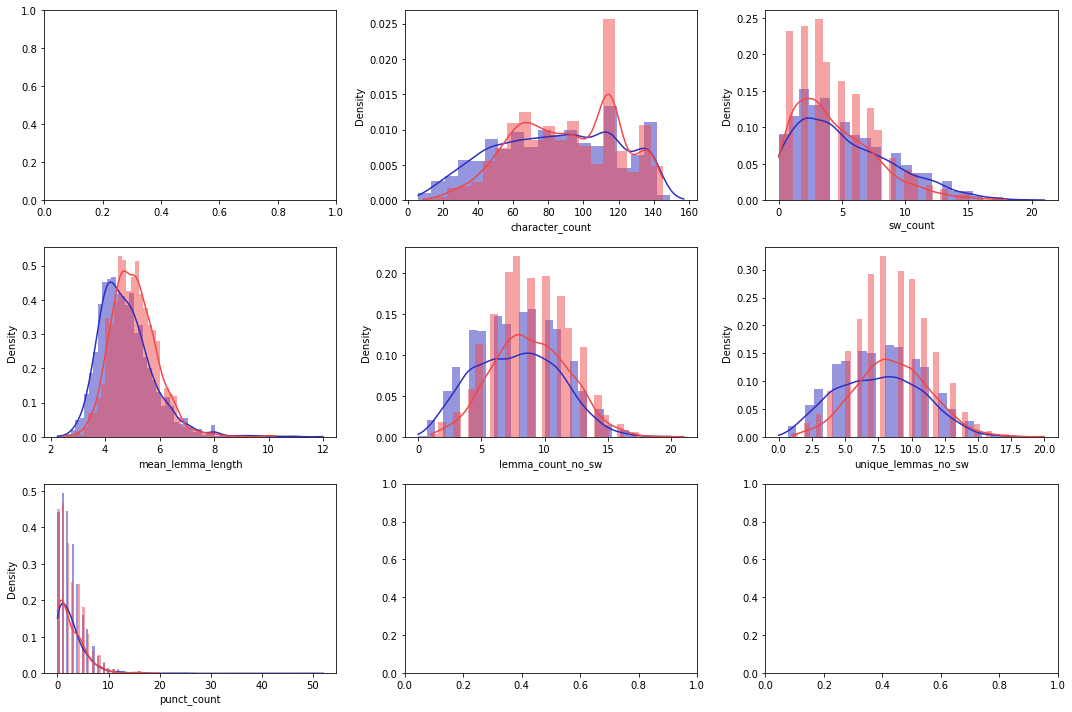

In [78]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15,10))
fl_ax = axes.flatten()

for idx, ftr in list(enumerate(meta_features_df_train.columns))[1:-2]:
    sns.histplot(meta_features_df_train[ftr][y_train==0], ax=fl_ax[idx], **kwargs_distplot, color=color_non)
    sns.histplot(meta_features_df_train[ftr][y_train==1], ax=fl_ax[idx], **kwargs_distplot, color=color_disaster)

plt.tight_layout()
plt.show()

# sns.countplot(meta_features_df_train['has_url'][y_train==0], ax=fl_ax[0], color=color_non)
# sns.countplot(meta_features_df_train['has_url'][y_train==1], ax=fl_ax[0], color=color_disaster)

In [ ]:
######################################################################################################
######################################################################################################
######################################################################################################
######################################################################################################
######################################################################################################
######################################################################################################
######################################################################################################
######################################################################################################
######################################################################################################
######################################################################################################
######################################################################################################
######################################################################################################
######################################################################################################
######################################################################################################
######################################################################################################
######################################################################################################
######################################################################################################

In [83]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler

In [193]:
tfidf = TfidfVectorizer(max_features=300, tokenizer=spacy_lemmatize, stop_words=stopword_list)
X_train_vec = tfidf.fit_transform(X_train['text'])
X_train_vec_df = pd.DataFrame(
    X_train_vec.toarray(), columns=tfidf.get_feature_names(), index=X_train.index
    )
X_train_combined_df = pd.concat(
    [
        X_train_vec_df, 
        pos_vectorized_df_train, 
        ner_vectorized_df_train, 
        meta_features_df_train
    ],
    axis=1
    )

X_test_vec = tfidf.transform(X_test['text'])
X_test_vec_df = pd.DataFrame(
    X_test_vec.toarray(), columns=tfidf.get_feature_names(), index=X_test.index
)
X_test_combined_df = pd.concat(
    [
        X_test_vec_df, 
        pos_vectorized_df_test, 
        ner_vectorized_df_test, 
        meta_features_df_test        
    ],
    axis=1
    )

X_train_combined_df.head()

c:\Users\zshoo\anaconda3\envs\learn-env\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'need', 'regard', 'shall', 'use', 'win'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


accident  air  airplane  ambulance  anniversary  apocalypse  area  army  \
1489       0.0  0.0       0.0   0.000000          0.0         0.0   0.0   0.0   
5973       0.0  0.0       0.0   0.000000          0.0         0.0   0.0   0.0   
7589       0.0  0.0       0.0   0.000000          0.0         0.0   0.0   0.0   
3788       0.0  0.0       0.0   0.459281          0.0         0.0   0.0   0.0   
825        0.0  0.0       0.0   0.000000          0.0         0.0   0.0   0.0   

      ass  atomic  ...  ORG  has_url  character_count  sw_count  \
1489  0.0     0.0  ...    0        0              135        15   
5973  0.0     0.0  ...    0        0               33         0   
7589  0.0     0.0  ...    0        0               14         0   
3788  0.0     0.0  ...    0        0              133        14   
825   0.0     0.0  ...    0        0               48         4   

      mean_lemma_length  lemma_count_no_sw  unique_lemmas_no_sw  punct_count  \
1489           4.818182                  7                    7            3   
5973           6.500000                  2                    2            0   
7589           6.500000                  2                    2            0   
3788           3.678571                 10                   10            4   
825            4.000000                  4                    4            1   

      hashtag_count  mention_count  
1489              0              1  
5973              1              0  
7589              0              0  
3788              0              0  
825               0              0  

[5 rows x 330 columns]

In [194]:
scaler = StandardScaler()
X_train_combined_df_scaled = scaler.fit_transform(X_train_combined_df)
X_train_combined_df_scaled = pd.DataFrame(X_train_combined_df_scaled, index=X_train.index, columns=X_train_combined_df.columns)

X_test_combined_df_scaled = scaler.transform(X_test_combined_df)
X_test_combined_df_scaled = pd.DataFrame(X_test_combined_df_scaled, index=X_test.index, columns=X_test_combined_df.columns)

In [195]:
###########################################################

In [196]:
X_train_combined_df_scaled.shape

(5709, 330)

In [271]:
from keras import models
from keras import layers
from keras import regularizers
from tensorflow.keras.metrics import Precision, Recall, AUC

precision = Precision()
recall = Recall()
auc = AUC()

baseline_model = models.Sequential()

baseline_model.add(layer=layers.Dense(
    units=75,
    activation='relu',
    input_shape=(X_train_combined_df_scaled.shape[1],),
    kernel_regularizer=regularizers.l2(0.005)
))

baseline_model.add(layers.Dropout(0.2))

baseline_model.add(layer=layers.Dense(
    units=25,
    activation='relu',
    kernel_regularizer=regularizers.l2(0.005)))

baseline_model.add(layer=layers.Dense(
    units=1,
    activation='sigmoid',
))

baseline_model.compile(
    optimizer='SGD',
    loss='binary_crossentropy',
    metrics=['accuracy', precision, recall, auc]
)

baseline_model_val = baseline_model.fit(
    np.array(X_train_combined_df_scaled),
    np.array(y_train),
    epochs=10,
    batch_size=8,
    validation_split=.25
)

Epoch 1/10
536/536 [==============================] - 2s 3ms/step - loss: 8.0966 - accuracy: 0.6534 - precision_55: 0.6117 - recall_53: 0.5334 - auc_53: 0.6823 - val_loss: 6.1528 - val_accuracy: 0.7220 - val_precision_55: 0.7261 - val_recall_53: 0.5521 - val_auc_53: 0.7746
Epoch 2/10
536/536 [==============================] - 1s 2ms/step - loss: 4.6324 - accuracy: 0.7659 - precision_55: 0.7835 - recall_53: 0.6305 - auc_53: 0.8217 - val_loss: 3.3468 - val_accuracy: 0.7598 - val_precision_55: 0.7500 - val_recall_53: 0.6496 - val_auc_53: 0.8109
Epoch 3/10
536/536 [==============================] - 1s 2ms/step - loss: 2.3955 - accuracy: 0.7828 - precision_55: 0.8137 - recall_53: 0.6424 - auc_53: 0.8481 - val_loss: 1.6837 - val_accuracy: 0.7661 - val_precision_55: 0.7705 - val_recall_53: 0.6380 - val_auc_53: 0.8231
Epoch 4/10
536/536 [==============================] - 1s 1ms/step - loss: 1.2625 - accuracy: 0.7877 - precision_55: 0.8289 - recall_53: 0.6386 - auc_53: 0.8529 - val_loss: 1.0400

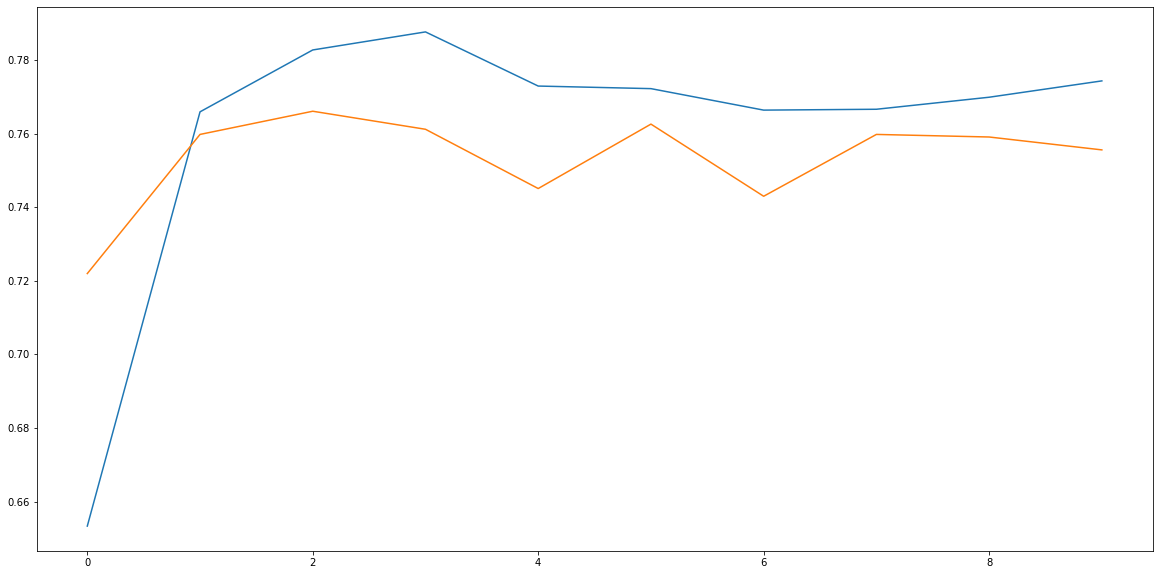

In [272]:
plt.figure(figsize=(20,10))
plt.plot(baseline_model_val.history['accuracy'])
plt.plot(baseline_model_val.history['val_accuracy'])

In [ ]:
###########################################################

In [89]:
some_model = RandomForestClassifier()
cross_val_score(some_model, X_train_combined_df, y_train, cv=5)

array([0.7408056 , 0.73817863, 0.74518389, 0.73292469, 0.73356705])

In [90]:
some_model.fit(X_train_combined_df_scaled, y_train)

RandomForestClassifier()

In [91]:
sorted(list(zip(X_train_combined_df_scaled.columns, some_model.feature_importances_.tolist())), key=lambda x: x[1], reverse=True)

[('mean_lemma_length', 0.08545244142030992),
 ('character_count', 0.07469037836261476),
 ('unique_lemmas_no_sw', 0.04733144475572535),
 ('lemma_count_no_sw', 0.043858345036531576),
 ('sw_count', 0.04366794778428648),
 ('punct_count', 0.04335855607921881),
 ('NOUN', 0.04323992434622779),
 ('ADP', 0.038364989133410105),
 ('PRON', 0.03735224243854557),
 ('PROPN', 0.03348124053566273),
 ('VERB', 0.030718102355695373),
 ('GPE', 0.029224460068467854),
 ('has_url', 0.02896877937058808),
 ('ADJ', 0.02858908917544091),
 ('hashtag_count', 0.021160877130126363),
 ('DET', 0.021004394237639765),
 ('AUX', 0.020840850000317532),
 ('mention_count', 0.020465216185063542),
 ('ADV', 0.0202657335285533),
 ('fire', 0.016692521153059275),
 ('PART', 0.015146097314155811),
 ('CCONJ', 0.013547127429273496),
 ('SCONJ', 0.011953849750967438),
 ('new', 0.009926325655188637),
 ('train', 0.00876377347947469),
 ('NORP', 0.008372111574955848),
 ('storm', 0.008123917263757373),
 ('ORG', 0.007969474055140072),
 ('kill'